Load packages 

In [4]:
library(magrittr)
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
“package ‘tibble’ was built under R version 3.4.1”Warning message:
“package ‘tidyr’ was built under R version 3.4.2”Warning message:
“package ‘purrr’ was built under R version 3.4.2”Warning message:
“package ‘dplyr’ was built under R version 3.4.2”Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


Read in data 

In [5]:
funnel    = read.table('funnel.csv',    sep = ",", header = TRUE)
loans     = read.table('loans.csv',     sep = ",", header = TRUE)
merchants = read.table('merchants.csv', sep = ",", header = TRUE)

Change `action_date` from factor to date 

In [3]:
funnel %<>% mutate(action_date  = as.Date(action_date,    format = "%a"))
#loans  %<>% mutate(checkout_date = as.Date(checkout_date, format = "%m/%d/%y"))

In [4]:
head(funnel)

merchant_id,user_id,checkout_id,action,action_date
D59QS30LK6F2IYOA,2291-6569-ZLWO,MP7KTW20X4LVWDQB,Checkout Loaded,2016-03-31
3XGCFF8YUFM65WSM,4927-7293-MJWN,UTYSI56OMVL9JW0C,Checkout Loaded,2016-01-29
H7GADDVO9CIZHMCL,0,2QV1BSCTSMBL6M0M,Checkout Loaded,2016-03-05
MNLK8D11U6PV4THN,0,ZM2PFHD1UUQBZHAC,Checkout Loaded,2016-03-27
H7GADDVO9CIZHMCL,0,CLPU7LY5JMOZQ7LU,Checkout Loaded,2016-03-09
H7GADDVO9CIZHMCL,8012-5297-ZMNY,RIXCCJN2ESZYQNOP,Checkout Loaded,2016-03-20


## Please review the integrity of the data. 
Do you notice any data anomalies? If so, please describe them.

The oldest user is 117 years old and 5 are over 100 years old. We may want to double-check this. Perhaps the customers were selecting birth year from the top of a drop-down list?

In [5]:
loans %>% 
  summarise(
    max.age = max(2016 - user_dob_year), 
    min.age = min(2016 - user_dob_year)
  )

loans %>% 
  filter((2016 - user_dob_year) > 100) %>% 
  summarise(n.over.100 = n())

max.age,min.age
117,19


n.over.100
5


FICO scores range from 300-850. Does 0 mean missing value? If we consider only positive FICO scores, then 450 is the minimum FICO score.

In [6]:
loans %>% 
  summarise(
    max.fico     = max(fico_score),
    min.fico     = min(fico_score),
    min.pos.fico = min(filter(., fico_score > 0) %>% select(fico_score))
  )

max.fico,min.fico,min.pos.fico
850,0,450


Some users borrowed very small loan amounts. I am not sure if those were test loans or if there's an error in the system.

In [7]:
loans %>% filter(loan_amount < 10) %>% count()

n
41


`loans.csv` contains 3016 more unique `checkout_id`s than `funnel.csv` does.

In [8]:
funnel %>% 
  filter(action == 'Checkout Completed') %>% 
  summarise(n.ids.funnel = n_distinct(checkout_id))

loans %>% 
  summarise(n.ids.loans = n_distinct(checkout_id))

n.ids.funnel
40671


n.ids.loans
43687


All the `checkout_id`s in the `funnel.csv` have a match in `loans.csv`. We can continue our analysis, but may want to check the query for `loans.csv`

In [9]:
funnel_checkout_ids <- funnel %>% 
  filter(action == 'Checkout Completed') %>% 
  select(checkout_id) 

loan_checkout_ids <- loans %>% 
  select(checkout_id) 

funnel_checkout_ids %>% 
  anti_join(loan_checkout_ids) %>% 
  count()

Joining, by = "checkout_id"
Warning message:
“Column `checkout_id` joining factors with different levels, coercing to character vector”

n
0


My time series plots (used in the second question) showed no data during 2016-02-22 and 2016-02-28. We should check for possible issues with the data pipeline.

In [10]:
funnel %>% 
  filter(between(action_date, as.Date('2016-02-22'), as.Date('2016-02-28'))) %>% 
  count()

n
0


There is one merchant in the `funnel.csv` that is not present in the merchants table. We should double-check the query for `merchants.csv`

In [11]:
funnel %>% 
  select(merchant_id) %>% 
  unique() %>%
  anti_join(merchants, by="merchant_id")

Warning message:
“Column `merchant_id` joining factors with different levels, coercing to character vector”

merchant_id
LWGKASO1U9UXFLAJ


That merchant shows up in the data at the end of March.

In [12]:
unknown.merchant <- funnel %>%
  filter(merchant_id == 'LWGKASO1U9UXFLAJ')
  
unknown.merchant %>%
  count()

unknown.merchant %>%
  select(action_date) %>%
  summary()

n
515


  action_date        
 Min.   :2016-03-21  
 1st Qu.:2016-03-24  
 Median :2016-03-27  
 Mean   :2016-03-26  
 3rd Qu.:2016-03-29  
 Max.   :2016-03-31  

## Calculate conversion through the funnel by day

Check number of unique records 

In [13]:
funnel %>% 
  distinct(checkout_id, action) %>% 
  count()

n
433326


Calculate daily funnel statistics 

In [14]:
calculate.funnel.stats <- function(funnel.tbl) {
  funnel.tbl %>%
    summarise(
      num_loaded        = sum(action == 'Checkout Loaded'),
      num_applied       = sum(action == 'Loan Terms Run'),
      num_approved      = sum(action == 'Loan Terms Approved'),
      num_confirmed     = sum(action == 'Checkout Completed'),
      application_rate  = round(num_applied   / num_loaded,   2),
      approval_rate     = round(num_approved  / num_applied,  2),
      confirmation_rate = round(num_confirmed / num_approved, 2)
    ) 
}

In [15]:
conversion <- funnel %>% 
  group_by(action_date) %>%
  calculate.funnel.stats()

head(conversion)

action_date,num_loaded,num_applied,num_approved,num_confirmed,application_rate,approval_rate,confirmation_rate
2016-01-01,1463,1070,663,397,0.73,0.62,0.60
2016-01-02,1802,1349,795,485,0.75,0.59,0.61
2016-01-03,1772,1339,810,488,0.76,0.60,0.60
2016-01-04,2012,1508,913,554,0.75,0.61,0.61
2016-01-05,2277,1585,899,577,0.70,0.57,0.64
2016-01-06,2080,1387,821,546,0.67,0.59,0.67


##  Data exploration

Plotting function for time series below

In [16]:
pointplot <- function(tbl, x, y, xlab, ylab, title){
  ggplot(tbl, aes_(x = x, y = y)) + 
    geom_point() +
    xlab(xlab) + 
    ylab(ylab) + 
    ggtitle(title) +
    theme_bw() +
    theme(
      axis.text  = element_text(size = 12),
      axis.title = element_text(size = 15),
      plot.title = element_text(hjust = 0.5, size = 16),
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank()
    )
}

###  Funnel time trends 
* Application rate showed a decrease trending since January but stayed relatively stable in March
* Approval rate continuously decreased and reached to its lowest point on late Febuary and started to increase back slightly in March
* Confirmation rate steadily increased since January

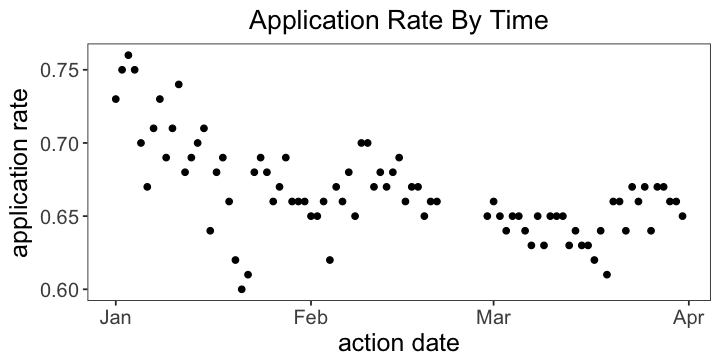

In [17]:
options(repr.plot.width=6, repr.plot.height=3)
pointplot(conversion, quo(action_date), quo(application_rate), "action date", "application rate", "Application Rate By Time")

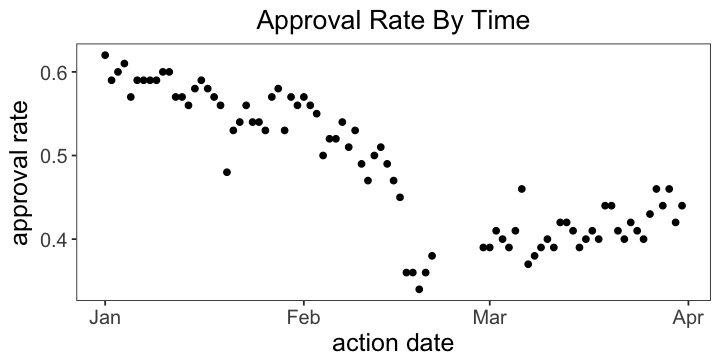

In [18]:
pointplot(conversion, quo(action_date), quo(approval_rate), "action date", "approval rate", "Approval Rate By Time")

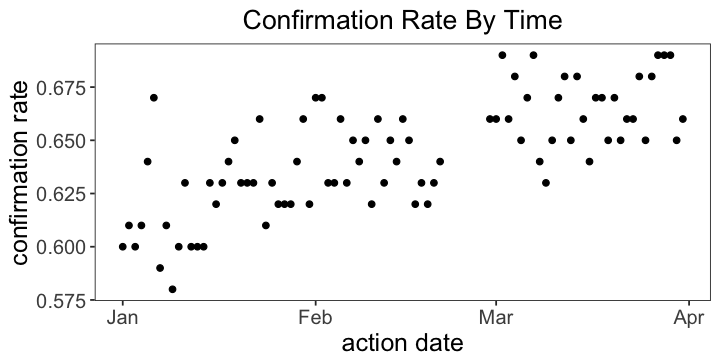

In [19]:
pointplot(conversion, quo(action_date), quo(confirmation_rate), "action date", "confirmation rate", "Confirmation Rate By Time")

###  Funnel statistics by merchant category
* Jewelry had a much lower confirmation rate than the other categories

In [20]:
funnel %>% left_join(merchants) %>%
  group_by(category) %>%
  calculate.funnel.stats() %>%
  arrange(c('Furniture', 'Apparel', 'Music', 'Jewelry', 'NA'))

Joining, by = "merchant_id"
Warning message:
“Column `merchant_id` joining factors with different levels, coercing to character vector”

category,num_loaded,num_applied,num_approved,num_confirmed,application_rate,approval_rate,confirmation_rate
Furniture,37230,25869,15198,10704,0.69,0.59,0.70
Apparel,97282,71717,37750,24621,0.74,0.53,0.65
Music,55613,28994,8591,4772,0.52,0.30,0.56
Jewelry,7577,4629,1725,539,0.61,0.37,0.31
NA,248,168,64,35,0.68,0.38,0.55


### Loan performance by merchant category
* Furniture generates the most revenue, followed by Apparel 

In [21]:
loans %>% 
  left_join(merchants, by = "merchant_id") %>% 
  group_by(category) %>%
  summarise(
    num_loans        = n(),
    revenue          = sum((mdr + loan_return_percentage) * loan_amount),
    revenue_per_loan = revenue / num_loans,
    avg.loans        = mean(loan_amount),
    avg.mdr          = mean(mdr),
    avg.apr          = mean(apr)
  ) %>%
  arrange(desc(revenue))

Warning message:
“Column `merchant_id` joining factors with different levels, coercing to character vector”

category,num_loans,revenue,revenue_per_loan,avg.loans,avg.mdr,avg.apr
Furniture,11485,1930907.793,168.12432,1230.5594,0.06766887,0.01298449
Apparel,26478,1152003.620,43.50795,536.2866,0.01968763,0.26070730
Music,5111,262905.220,51.43910,599.3689,0.02273841,0.26167140
Jewelry,578,155065.437,268.27930,3116.6638,0.02774913,0.22059740
NA,35,4594.108,131.26022,1145.3257,0.03500000,0.23767714


### Loan performance by age
I focused on users between 18 and 80. Would want to check if the older age values are reliable and whether customers younger than 18 can apply for loans.
* Users between 30 and 50 generated the most revenue. 

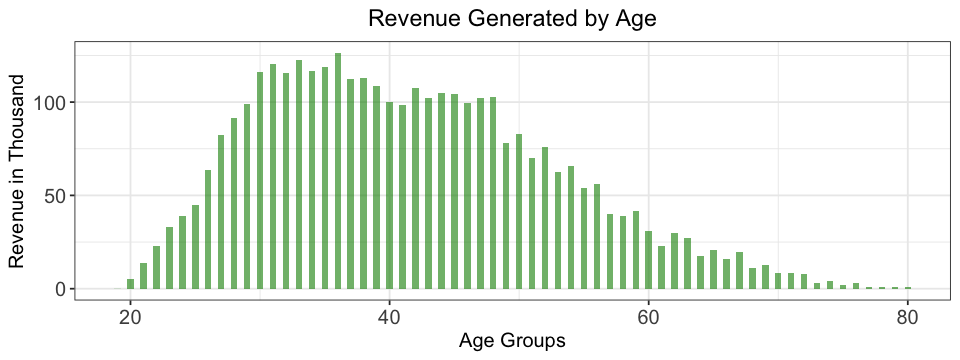

In [22]:
options(repr.plot.width=8, repr.plot.height=3)

loans %>% 
  mutate(age = 2016 - user_dob_year) %>%
  filter(between(age, 18, 80)) %>%
  group_by(age) %>%
  summarise(
    num_loans = n(),
    revenue = sum((mdr + loan_return_percentage) * loan_amount)
  ) %>% 
  ggplot(aes(x = age, y = revenue / 1000)) + 
    geom_bar(stat = 'identity', width = 0.5, fill = 'green4', alpha = 0.6) +
    xlab('Age Groups') + 
    ylab('Revenue in Thousand') +
    ggtitle("Revenue Generated by Age") + 
    theme_bw() + 
    theme(
      axis.text  = element_text(size = 12),
      axis.title = element_text(size = 12),
      plot.title = element_text(hjust = 0.5, size = 14)
    )

### Loan performance by FICO score
I filtered out FICO scores that were not within the range of 300 to 850.
* Users with FICO scores between 620 and 680 generated the majority of revenue 

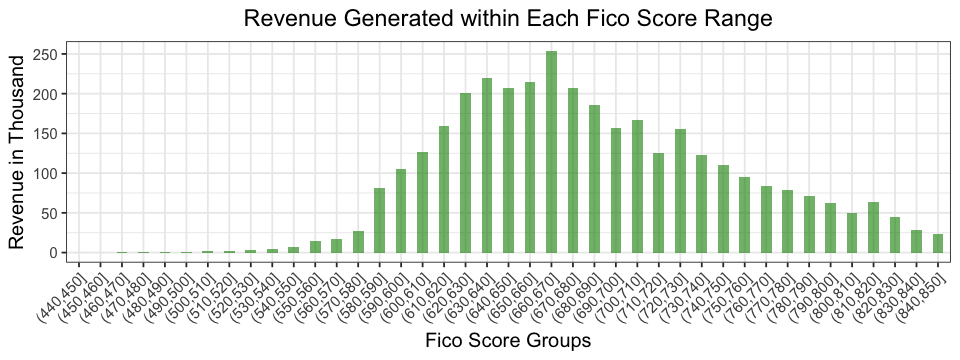

In [23]:
loans %>% 
  mutate(age = 2016 - user_dob_year) %>%
  filter(
    between(fico_score, 300, 850) & 
    between(age, 18, 80)) %>%
  mutate(
    cat_fico_score = cut(fico_score, seq(300, 850, 10))
  )%>%
  group_by(cat_fico_score) %>%
  summarise(
      num_loans = n(),
      revenue = sum((mdr + loan_return_percentage) * loan_amount)
  ) %>%
  ggplot(aes(x = cat_fico_score, y = revenue / 1000)) + 
    geom_bar(stat = 'identity', width = 0.5, fill = 'green4', alpha = 0.6)+
    xlab('Fico Score Groups') + 
    ylab('Revenue in Thousand')+
    ggtitle("Revenue Generated within Each Fico Score Range") + 
    theme_bw()+ 
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      axis.text   = element_text(size = 9),
      axis.title  = element_text(size = 12),
      plot.title  = element_text(hjust = 0.5, size = 14))

### FICO scores vs age
* FICO scores are similar across age groups between 30 to 50. This is not surprising, since we are only looking at those customers who have been approved and took the loans.

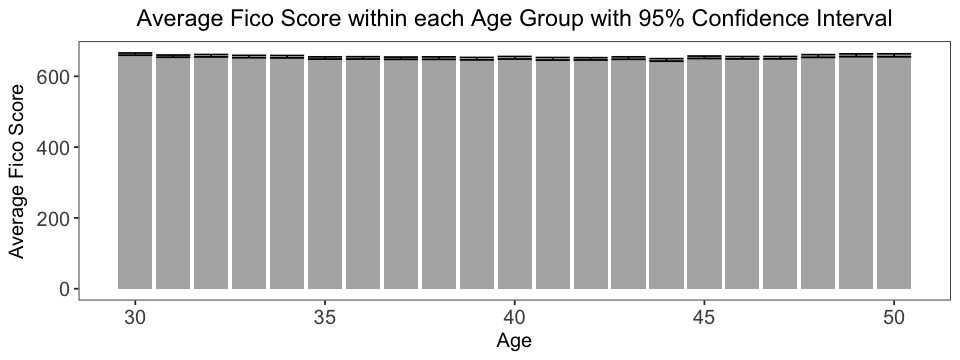

In [24]:
loans %>%
  mutate(age = 2016 - user_dob_year) %>%
  filter(
    between(age, 30, 50) & 
    between(fico_score, 300, 850)
  ) %>%
  group_by(age) %>%
  summarise(
    mean.fico = mean(fico_score, na.rm = TRUE),
    sd.fico   = sd(fico_score, na.rm = TRUE),
    n.fico    = n()) %>%
  mutate(
    se.fico       = sd.fico / sqrt(n.fico),
    lower.ci.fico = mean.fico - qt(1 - (0.05 / 2), n.fico - 1) * se.fico,
    upper.ci.fico = mean.fico + qt(1 - (0.05 / 2), n.fico - 1) * se.fico)  %>%
  ggplot(aes(x=age, y=mean.fico, ymin=lower.ci.fico, ymax=upper.ci.fico)) + 
    geom_bar(stat='identity', alpha=0.5) + 
    geom_errorbar() + 
    xlab('Age') +
    scale_y_continuous(name='Average Fico Score') + 
    ggtitle("Average Fico Score within each Age Group with 95% Confidence Interval") + 
    theme_bw() + 
    theme(
      axis.text  = element_text(size = 12),
      axis.title = element_text(size = 12),
      plot.title = element_text(hjust = 0.5, size = 14),
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank()
    )

### Repeat customers
* 34.6% of customers are repeat customers.
* Repeat customers generated less revenue per user than one-time customers during the observed time period. 
* Repeat customers borrowed smaller loan amounts than that of one-time customers.
* Merchant discounts were much lower for repeat customers.

In [8]:
boxplot <- function(tbl, x, y, name, ylim){   
    x <- enquo(x)
    y <- enquo(y)
    tbl %>% 
    ggplot(aes_(x = x, y = y)) +
      geom_boxplot() +
      xlab('') +
      scale_y_continuous(name = name, limits = ylim) + 
      ggtitle("") + 
      theme_bw() + 
      theme(
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        plot.title = element_text(hjust = 0.5, size = 14),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank()
      )
}

Revenue in one-time vs repeat customers

Warning message:
“Removed 5980 rows containing non-finite values (stat_boxplot).”

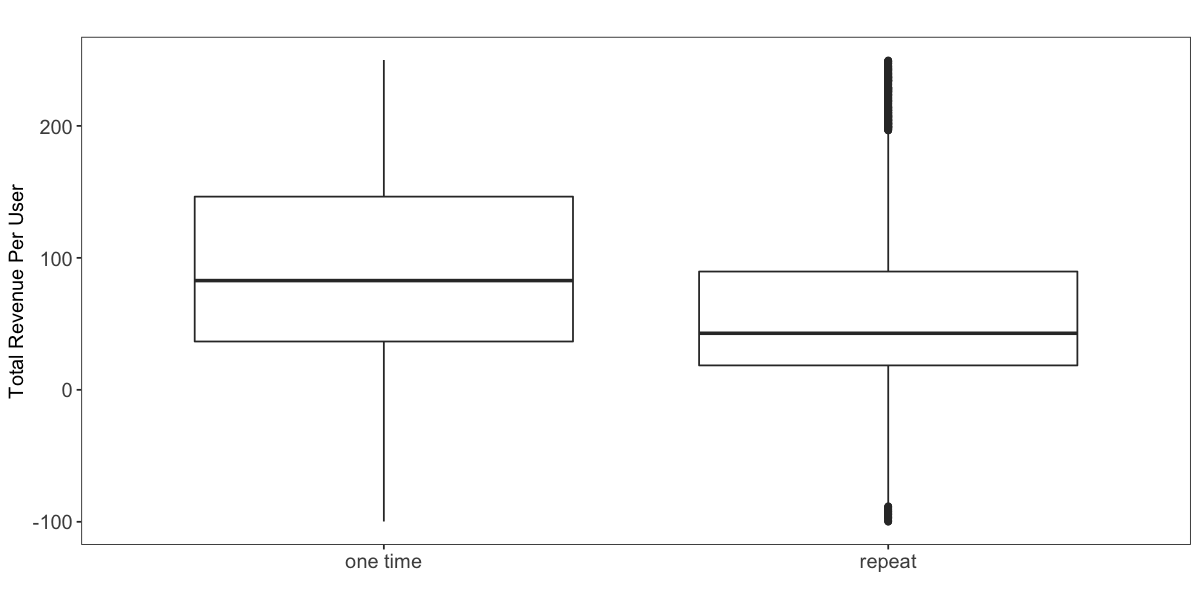

In [14]:
loans %>% 
  mutate(repeat_customer = ifelse(users_first_capture != 0, 'repeat', 'one time')) %>%
  group_by(user_id, repeat_customer) %>%
  summarise(
    num_loans = n(),
    revenue = sum((mdr + loan_return_percentage) * loan_amount),        
  ) %>%
  boxplot(repeat_customer, revenue, 'Total Revenue Per User', c(-100, 250))

Loan amount in one-time vs repeat customers

Warning message:
“Removed 8522 rows containing non-finite values (stat_boxplot).”

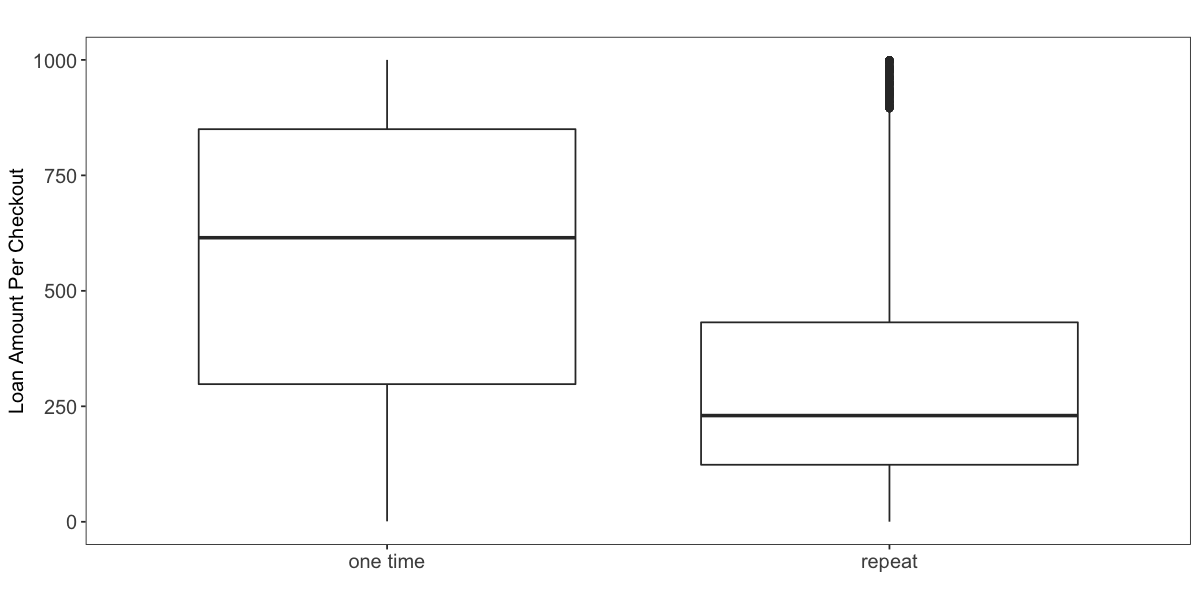

In [12]:
loans %>% 
  mutate(repeat_customer = ifelse(users_first_capture != 0, 'repeat', 'one time')) %>%
  boxplot(repeat_customer, loan_amount,'Loan Amount Per Checkout', c(0, 1000))

Merchant discount rate in one-time vs repeat customers

Warning message:
“Removed 147 rows containing non-finite values (stat_boxplot).”

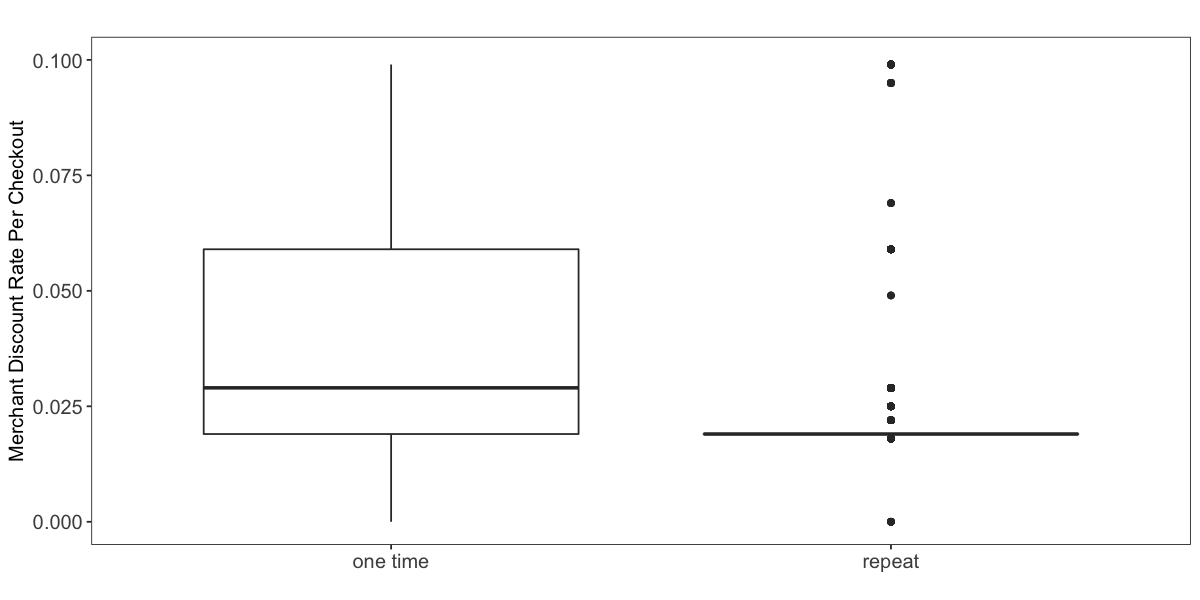

In [13]:
loans %>% 
  mutate(repeat_customer = ifelse(users_first_capture != 0, 'repeat', 'one time')) %>%
  boxplot(., repeat_customer, mdr, 'Merchant Discount Rate Per Checkout', c(0, 0.1))        